## Dataset

The dataset used is the [German Traffic Signs Dataset](https://medium.com/datadriveninvestor/traffic-sign-recognition-using-convolutional-neural-networks-cnn-f7dc5d9d53ba) containing images of shape (32x32x3)



*   The training set has 34799 images
*   The validation set has 4410 images
*   The test set has 12630 images
*   The dataset has 43 unique classes


**Structure:**
*  One directory per class
*  Each directory container CSV file wit annotations name: GT\<class id \>.csv and the training images
*  training images grouped by tracks (each track has 30 images of one single traffic sign)


**Annotation structure:**
+  CSV with 8 columns
    +  **Filename**
    + **Width**
    + **Height**
    + **x of top left corner**
    + **y of top left corner**
    + **x bottom right corner**
    + **y of bottom right corner**
    + **class id**


We are going to use the same dataset with the [training](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip) and [test](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip) data in a different format.

You can get the train data [here](https://drive.google.com/file/d/1AZeKw90Cb6GgamTBO3mvDdz6PjBwqCCt/view) with the label values [here](https://www.murtazahassan.com/wp-content/uploads/2020/08/labels.zip)

In [ ]:
%%bash
rm -rf train
rm labels.csv

In [ ]:
%%bash
unzip myData.zip
mkdir train
mv myData/* train
rm -rf myData

In [ ]:
%%bash
unzip labels.zip

# Train Script

Install Tensorflow (we will install the gpu version, needs CUDA supported device)

In [ ]:
%%bash
source env/bin/activate
pip install tensorflow-gpu
pip install matplotlib
pip install opencv-python
pip install Keras
pip install -U scikit-learn
pip install pandas

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline 

## Importing data

In [40]:
path = "train" # folder with all the class folders
label_file = 'labels.csv' # file with all names of classes
batch_size = 50  # how many to process together
steps_per_epoch = 2000
epochs = 20
img_dim = (32,32,3)
test_ratio = 0.2    # if 1000 images split will 200 for testing
val_ratio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation

In [11]:
def importImages(path):
  count = 0
  images = []
  classNo = []
  class_files = os.listdir(path)
  print("Total Classes Detected:",len(class_files))
  number_classes=len(class_files)
  print("Importing Classes.....")
  for x in range (0,len(class_files)):
      myPicList = os.listdir(path+"/"+str(count))
      for y in myPicList:
          curr_img = cv2.imread(path+"/"+str(count)+"/"+y)
          images.append(curr_img)
          classNo.append(count)
      print(count, end =" ")
      count +=1
  print(" ")
  images = np.array(images)
  classNo = np.array(classNo)
  return images,classNo,number_classes

In [12]:
images, class_n,number_classes = importImages(path)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


## Spliting data

In [13]:
def splitData(images,class_n,test_ratio,val_ratio):
    x_train, x_test, y_train, y_test = train_test_split(images, class_n, test_size=test_ratio)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_ratio)

    return x_train,x_test,x_val,y_train,y_test,y_val

In [14]:
 x_train,x_test,x_val,y_train,y_test,y_val = splitData(images,class_n,test_ratio,val_ratio)

Check if n of images = n of labels

In [16]:
print("Data Shapes")
print("Train",end = "");print(x_train.shape,y_train.shape)
print("Validation",end = "");print(x_val.shape,y_val.shape)
print("Test",end = "");print(x_test.shape,y_test.shape)
assert(x_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(x_val.shape[0]==y_val.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(x_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(x_train.shape[1:]==(img_dim))," The dimesions of the Training images are wrong "
assert(x_val.shape[1:]==(img_dim))," The dimesionas of the Validation images are wrong "
assert(x_test.shape[1:]==(img_dim))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


## Read label file

In [17]:
data = pd.read_csv(label_file)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


## Data visualization

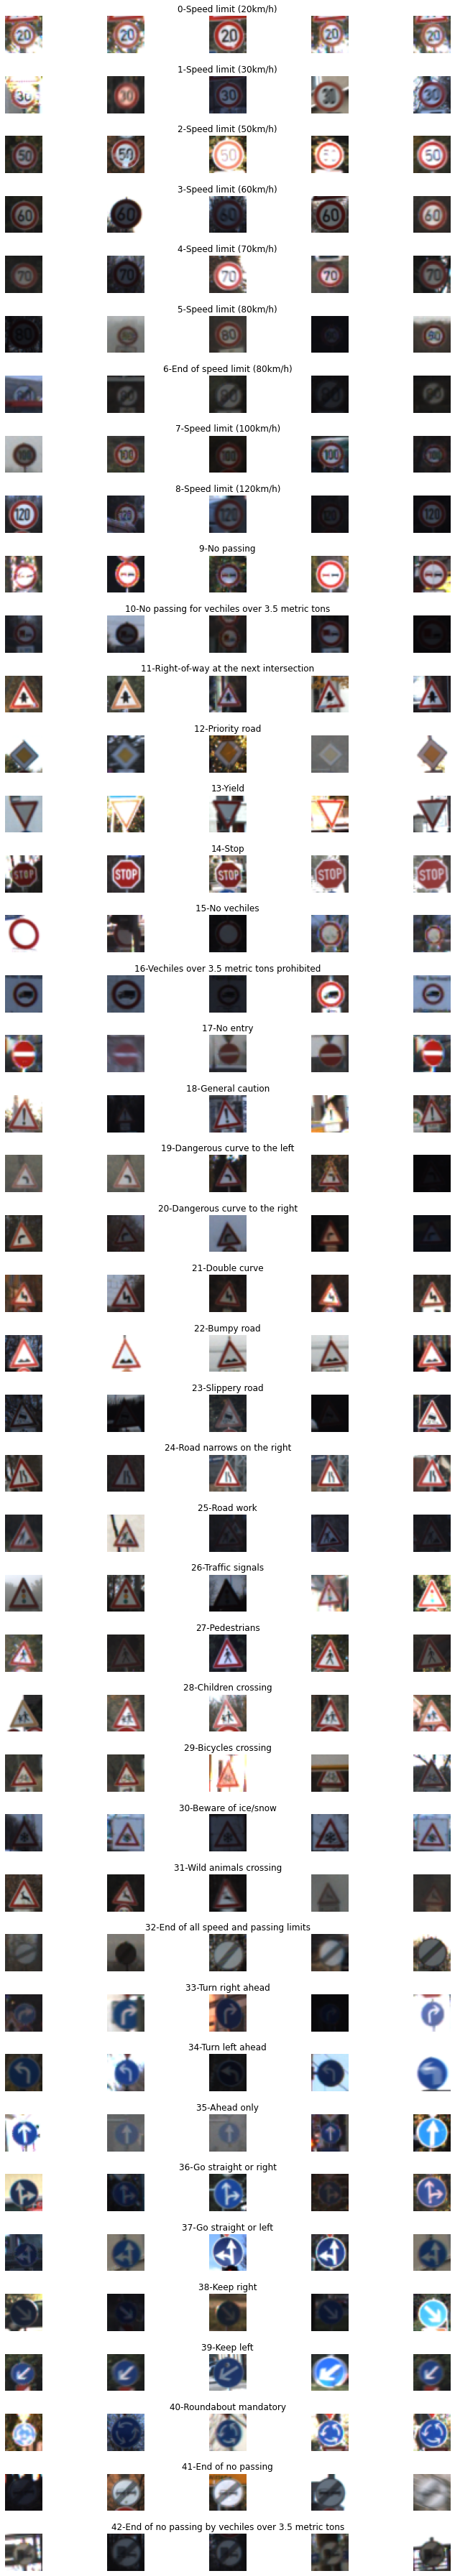

In [19]:
num_of_samples = []
cols = 5
fig, axs = plt.subplots(nrows=number_classes, ncols=cols, figsize=(10, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

Bar plot with data statistics

[121, 1258, 1306, 796, 1136, 1103, 226, 836, 795, 831, 1144, 771, 1215, 1219, 470, 351, 234, 617, 654, 113, 179, 174, 219, 275, 143, 839, 361, 125, 318, 155, 251, 458, 126, 394, 227, 672, 208, 111, 1177, 185, 199, 145, 134]


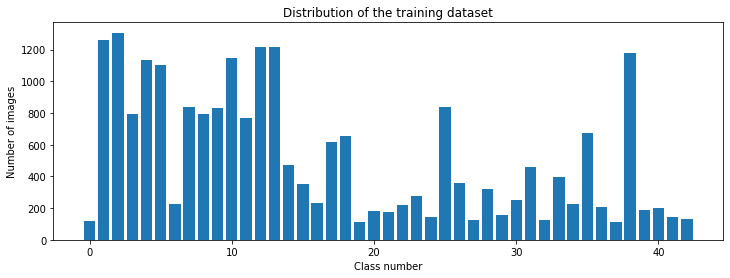

In [20]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, number_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

## Preprocessing

In [21]:
grayScale = lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
histogramEqualize = lambda img: cv2.equalizeHist(img)

In [22]:
def preprocessImage(img):
  #convert to grayscale
  img = grayScale(img)
  #Histogram equalization to standardize light
  img = histogramEqualize(img)
  #Normalize values between 0 and 1
  img = img/255
  return img

In [23]:
#Preprocess dataset
x_train = np.array(list(map(preprocessImage,x_train)))
x_val = np.array(list(map(preprocessImage,x_val)))
x_test = np.array(list(map(preprocessImage,x_test)))

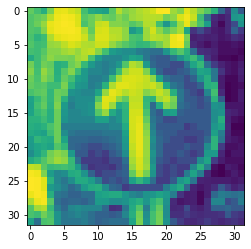

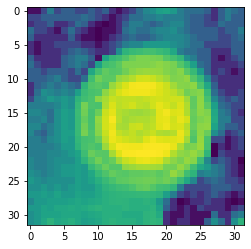

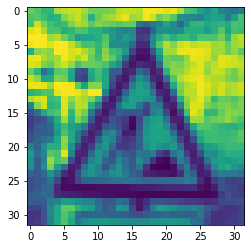

In [24]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)])
plt.show()
plt.imshow(x_val[random.randint(0,len(x_val)-1)])
plt.show()
plt.imshow(x_test[random.randint(0,len(x_test)-1)])
plt.show()

In [25]:
#Add depth
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_val=x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

## Image Augmentation

In [26]:
data_generator= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES

data_generator.fit(x_train)

In [27]:
batches= data_generator.flow(x_train,y_train,batch_size=20)

In [28]:
x_batch,y_batch = next(batches)

Show augmented data

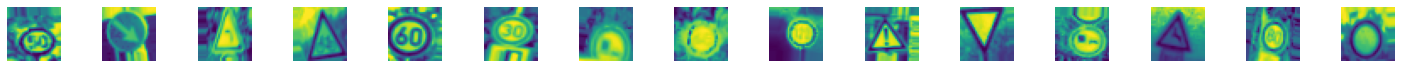

In [30]:
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(x_batch[i].reshape(img_dim[0],img_dim[1]))
    axs[i].axis('off')
plt.show()

### Multivariate normalization

In [31]:
y_train = to_categorical(y_train,number_classes)
y_val = to_categorical(y_val,number_classes)
y_test = to_categorical(y_test,number_classes)

## CNN Model

In [33]:
def buildModel(input_dim,n_classes):
  n_filters = 60
  size_filter1 = (5,5) #Size of kernel that will move arround
  size_filter2 = (3,3)
  size_pooling = (2,2)

  n_nodes = 500

  model = Sequential()
  #More conv layers ==> less features tested
  model.add(Conv2D(
      n_filters,
      size_filter1,
      input_shape=input_dim,
      activation = 'relu'
      ))
  
  model.add(Conv2D(
      n_filters,
      size_filter1,
      activation = 'relu'
  ))

  model.add(MaxPooling2D(pool_size=size_pooling))
  model.add(Conv2D(
      n_filters//2,
      size_filter2,
      activation = 'relu'
  ))
  model.add(Conv2D(
      n_filters//2,
      size_filter2,
      activation = 'relu'
  ))

  model.add(MaxPooling2D(pool_size=size_pooling))

  #Drop 50%
  model.add(Dropout(0.5))

  #Dense layer
  model.add(Flatten())
  model.add(Dense(n_nodes,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes,activation='softmax'))

  #compile model
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [34]:
model = buildModel((img_dim[0],img_dim[1],1),number_classes)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

In [42]:
history = model.fit_generator(
    data_generator.flow(x_train,y_train,batch_size=batch_size),
    steps_per_epoch=50,
    epochs=epochs,
    validation_data=(x_val,y_val),
    shuffle=1
)

Epoch 1/20
50/50 [==============================] - 4s 89ms/step - loss: 1.1820 - accuracy: 0.6416 - val_loss: 0.4663 - val_accuracy: 0.8761
Epoch 2/20
50/50 [==============================] - 4s 87ms/step - loss: 1.1440 - accuracy: 0.6468 - val_loss: 0.4316 - val_accuracy: 0.8791
Epoch 3/20
50/50 [==============================] - 4s 88ms/step - loss: 1.1241 - accuracy: 0.6568 - val_loss: 0.3770 - val_accuracy: 0.8994
Epoch 4/20
50/50 [==============================] - 4s 88ms/step - loss: 1.0555 - accuracy: 0.6820 - val_loss: 0.3848 - val_accuracy: 0.8971
Epoch 5/20
50/50 [==============================] - 4s 87ms/step - loss: 1.0441 - accuracy: 0.6684 - val_loss: 0.3238 - val_accuracy: 0.9003
Epoch 6/20
50/50 [==============================] - 4s 90ms/step - loss: 0.9686 - accuracy: 0.7100 - val_loss: 0.2567 - val_accuracy: 0.9273
Epoch 7/20
50/50 [==============================] - 4s 88ms/step - loss: 0.9801 - accuracy: 0.7048 - val_loss: 0.3429 - val_accuracy: 0.9018
Epoch 8/20
50

### Evaluation

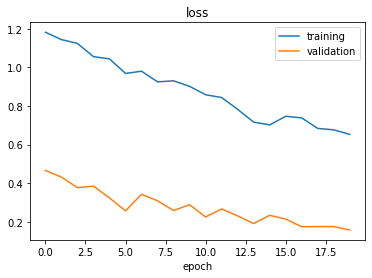

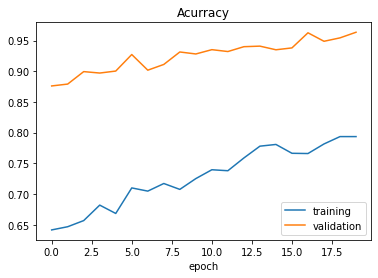

Test Score: 0.16411107778549194
Test Accuracy: 0.9612069129943848


In [43]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(x_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [44]:
model.save('model.h5')

# Test model

In [45]:
import numpy as np
import cv2
import pickle
from tensorflow.keras.models import load_model

In [46]:
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75         # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

In [47]:
path = ""

In [48]:
grayScale = lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
histogramEqualize = lambda img: cv2.equalizeHist(img)

In [49]:
def preprocessImage(img):
  #convert to grayscale
  img = grayScale(img)
  #Histogram equalization to standardize light
  img = histogramEqualize(img)
  #Normalize values between 0 and 1
  img = img/255
  return img

In [50]:
class_keys = [
    'Speed Limit 20 km/h',
    'Speed Limit 30 km/h',
    'Speed Limit 50 km/h',
    'Speed Limit 60 km/h',
    'Speed Limit 70m/h',
    'Speed Limit 80km/h',
    'End of Speed Limit 80 km/h',
    'Speed Limit 100 km/h',
    'Speed Limit 120 km/h',
    'No passing',
    'No passing for vechiles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield',
    'Stop',
    'No vechiles',
    'Vechiles over 3.5 metric tons prohibited',
    'No entry','General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve',
    'Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right',
    'Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vechiles over 3.5 metric tons'
]

class_dict = {i : v for i,v in enumerate(class_keys)}

In [51]:
class_dict

{0: 'Speed Limit 20 km/h',
 1: 'Speed Limit 30 km/h',
 2: 'Speed Limit 50 km/h',
 3: 'Speed Limit 60 km/h',
 4: 'Speed Limit 70m/h',
 5: 'Speed Limit 80km/h',
 6: 'End of Speed Limit 80 km/h',
 7: 'Speed Limit 100 km/h',
 8: 'Speed Limit 120 km/h',
 9: 'No passing',
 10: 'No passing for vechiles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vechiles',
 16: 'Vechiles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or ri